![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 12.1 - Network Visualization (PyTorch).ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 12.1 - Network Visualization (PyTorch).ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>


# Task 12 part 1 - Network Visualization (PyTorch)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.


Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = "1301170073"
Nama = "Pratama Yoga S"

## --- end your code here ----

---
---
#[Part 0] Import Libraries and Load Data

In [2]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

---
## 1 - Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. 

We define a few helper functions for performing and undoing this preprocessing. 

You don't need to do anything in these cells.

---
### a. Preprocess Image

preprocess image by normalizeing (zero centering) according to `squeezenet` model

you need to change the function if you use another pretrained model

In [3]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

---
### b. De-Process Image
Denormalize back image for viewing purpose

again, you need to change the function if you use another pretrained model

In [4]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

---
### c. Blur Image

Image jittering by blurring the image

In [5]:
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

---
## 2 - ImageNet Validation
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. 

Since they come from the validation set, our pretrained model did not see these images during training.



---
### a. Load Imagenet Validation

In [6]:
!wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/imagenet_val_25.npz' -q

In [7]:
def load_imagenet_val(num=None):
    f = np.load('imagenet_val_25.npz', allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    idx = np.arange(25)
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
        X   = X[idx]
        y   = y[idx]
    return X, y, class_names

Now load randomly some image for this exercise

you can change the `num=5` to get more image from `imagenet validation set`. 

The maximum is `25` or `None`

In [8]:
X, y, class_names = load_imagenet_val(num=5)

---
### b. View Images
Run the following cell to visualize some of these images, along with their ground-truth labels.

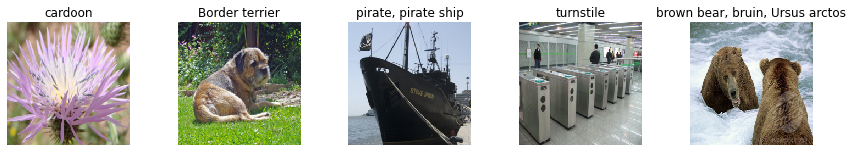

In [9]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

---
---
# [Part 1] SqueezeNet Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

But you can try any other model from PyTorch. See the list [here](https://pytorch.org/docs/stable/torchvision/models.html)

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

---
## 1 - Load SqueezeNet

Download and load the pretrained SqueezeNet model.

In [10]:
model = torchvision.models.squeezenet1_1(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth



SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2

---
## 2 - Freeze the Model
We don't want to train the model, so tell PyTorch not to compute gradients
with respect to model parameters.

you may see warning regarding initialization deprecated, that's fine, please continue to next steps


In [11]:
for param in model.parameters():
    param.requires_grad = False

---
---
# [Part 2] Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of paper [[2]](https://arxiv.org/abs/1312.6034).

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

---
## 1 - PyTorch `gather` method
Recall in previous exercises you needed to select one element from each row of a matrix; 
* if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, 
* then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method.

---
run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [12]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print('s =\n', s)
    print('y        = ',y)
    print('s.gather = ',s.gather(1, y.view(-1, 1)).squeeze())
    

In [13]:
gather_example()

s =
 tensor([[ 0.9051, -0.9527, -0.3271,  0.7616, -1.5441],
        [ 0.2486, -0.4142,  0.2037,  0.6522, -0.3551],
        [ 0.7110,  1.5254, -1.1589,  1.4951,  0.0345],
        [ 0.3422, -0.5301,  0.1165, -0.6353,  0.4823]])
y        =  tensor([1, 2, 1, 3])
s.gather =  tensor([-0.9527,  0.2037,  1.5254, -0.6353])


**Expected Output**:
<pre>
s = 
tensor([[ ??,   <b>A</b>,  ??,  ??,  ??],
        [ ??,  ??,   <b>B</b>,  ??,  ??],
        [ ??,   <b>C</b>,  ??,  ??,  ??],
        [ ??,  ??,  ??,   <b>D</b>,  ??]])
<i>*example of random values</i>

y        =  tensor([1, 2, 1, 3])
s.gather =  tensor([<b>A</b>, <b>B</b>, <b>C</b>, <b>D</b>])
<i>*tensor with number gathered from respective column from tensor s</i>

---
## 2 - Saliency Map Function

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. 

To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. 
* If the image has shape $(3\times \text{H}\times \text{W})$ then this gradient will also have shape $(3\times \text{H}\times \text{W})$; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. 
* To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape $(\text{H}\times \text{W})$ and all entries are nonnegative.

---
#### <font color='red'>**EXERCISE:** </font>

Implement this function. 
* Perform a forward and backward pass through the model to compute the gradient of the correct class score with respect to each input image. 
* You first want to compute the loss over the correct scores (we'll combine losses across a batch by summing), 
* and then compute the gradients with a backward pass. 



In [14]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    # 1. Forward pass
    # calculate forward pass from model with input X
    scores = model(X)
    
    # 2. Get correct class scores
    # call gather() function from scores tensor, 
    # with input 1 and y.view(-1, 1)
    # then squeeze it by calling .squeeze() function
    # (see the gather method example)
    scores = scores.gather(1, y.view(-1,1)).squeeze()
    
    # 3. Backward pass
    # Note: scores is a tensor here, need to supply initial gradients of same tensor shape as scores.
    # get scores size
    scores_size = scores.shape

    # create ones tensor matrix with size of scores
    # call torch.ones() function with inpput scores_size
    ones_tensor = torch.ones(scores_size)
    
    
    # call .backward() function from scores tensor with input ones_tensor
    scores.backward(ones_tensor)

    # 4. retrieve the gradient as saliency map
    saliency = X.grad
    
    # 5. Convert 3d to 1d
    saliency = saliency.abs()
    saliency, _= torch.max(saliency, dim=1)
    
    return saliency

---
## 3 - Show Saliency Map
Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

In [15]:
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

# Compute saliency maps for images in X
saliency = compute_saliency_maps(X_tensor, y_tensor, model)

# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
saliency = saliency.numpy()

visualize the saliency

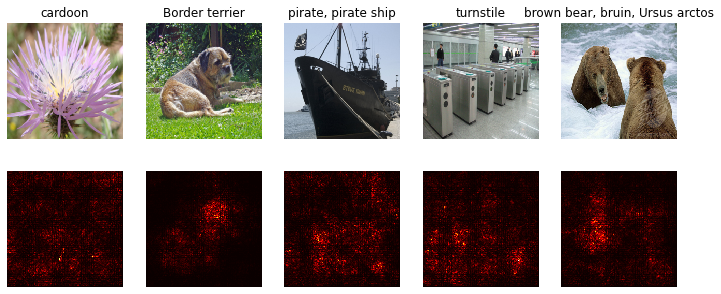

In [16]:
N = X.shape[0]
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

You can try for another image by loading another random images, then re-run the 2 cells above

In [17]:
X, y, class_names = load_imagenet_val(num=5)

---
---
# [Part 3] Class Visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. 

This idea was first presented in [[2]](https://arxiv.org/abs/1312.6034); then
[[3]](https://arxiv.org/abs/1506.06579) extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

---
Concretely,
* Let $I$ be an image and let $y$ be a target class.
* Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$;
   * note that these are raw unnormalized scores, not class probabilities. 
* We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem
$$
I^* = \arg\max_I (s_y(I) - R(I))
$$
where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). 
* We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. 

* We will use (explicit) L2 regularization of the form
$$
R(I) = \lambda \|I\|_2^2
$$
* **and** implicit regularization as suggested by [3] by periodically blurring the generated image. 

We can solve this problem using gradient ascent on the generated image.

***
## 1 - Jittering Function
Helper function to randomly jitter and blur an image.


In [18]:
def jitter(X, ox, oy):
    """    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left  = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top    = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

---
## 2 - Class Visualization Function

Implement function to Generate an image to maximize the score of target_y under a pretrained model.

---
#### <font color='red'>**EXERCISE:** </font>

complete the implementation of the `create_class_visualization` function.

* Use the model to compute the gradient of the score for the  class `target_y` with respect to the pixels of the image, 
* then make a gradient step on the image using the learning rate. 
* Don't forget the L2 regularization term!
* Be very careful about the signs of elements in your code.            

<br>

 **NOTE**:

 if `x` is a tensor, the value of `x` can be retrieved by calling `x.data`



In [25]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """

    # prepare the hyperparameters
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        # 1. Forward pass
        #    calculate forward pass from model() with input img        
        #    (see the implementation from compute_saliency_maps function above)
        scores = model(img)
        
        #    get the target score
        target_score = scores[0, target_y]
        
        #    perform backward pass from target_score by calling .backward() function
        target_score.backward()
        
        # 2. perform L2 regularization
        #    get the image gradient value by calling img.grad.data
        grad = img.grad.data
        
        #    new grad is old grad subtracted by 2 * l2_reg * img.data
        grad -= 2 * l2_reg * img.data
        
        # 3. update image using gradient ascent
        #    new img.data is the old img.data added by learning rate * (grad / grad.norm()) 
        img.data =img.data + (learning_rate * (grad / grad.norm())) 
        
        #    reset img.grad by calling .zero_() function
        img.grad.zero_()
                
        # 3. Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image result
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

---
## 3 - Show Class Visualization

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

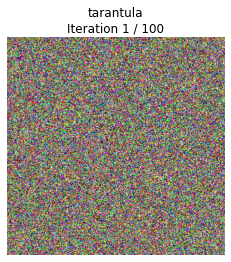

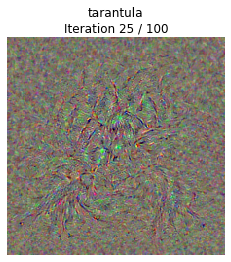

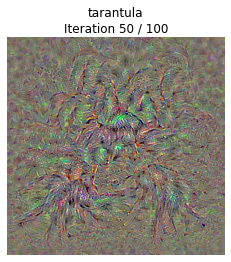

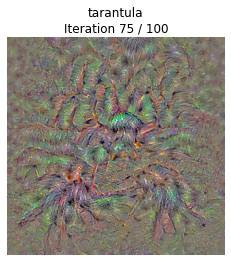

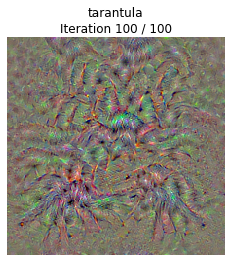

In [26]:
dtype = torch.cuda.FloatTensor
model.type(dtype)

# uncomment target that you want to visualize
target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass

out = create_class_visualization(target_y, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

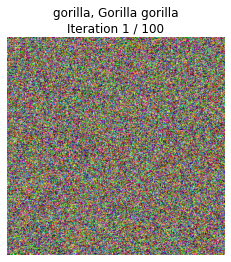

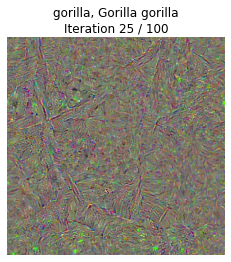

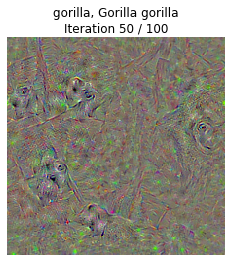

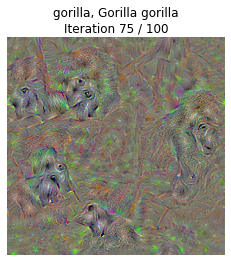

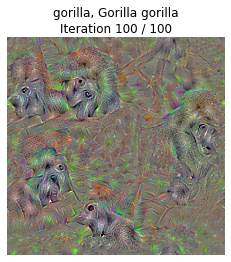

In [27]:
# target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
target_y = 366 # Gorilla
# target_y = 604 # Hourglass

out = create_class_visualization(target_y, model, dtype)

---
---
# [Part 4] Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [[4]](https://arxiv.org/abs/1312.6199). 

Given an image and a target class, we can perform **gradient ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. 


[4] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

---
## 1 - Fooling Image Function

                                                                          
For most examples, you should be able to generate a fooling image in fewer than 100 iterations of gradient ascent.  

---
#### <font color='red'>**EXERCISE:** </font>

Implement the following function to generate fooling images.

* Generate a fooling image `X_fooling` that the model will classify as the class `target_y`. 
* You should perform **gradient ascent** on the score of the target class, stopping when the model is fooled.     
* When computing an update step, first normalize the gradient:              
  $dX = learning\_rate * \dfrac{g}{||g||}$
                        




In [33]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1

    
    for i in range(100):
                
        # Forward pass
        # calculate forward pass from model with input X_fooling
        # (see the implementation from compute_saliency_maps function above)
        scores = model(X_fooling)
        
        # get the current maximum scores index
        # use torch.argmax() function with input scores and dim=1
        index = torch.argmax(scores, dim=1)
        
        # if the maximum score (index[0]) is equal to target_y, 
        # break the process
        if index[0] == target_y:
            break
            
        # get the target score
        target_score = scores[0, target_y]
        
        # perform backward pass from target_score by calling backward() function
        target_score.backward()
        
        # get the X_fooling image gradient value 
        # by calling X_fooling.grad.data
        grad = X_fooling.grad.data
        
        # Update image using graident ascent
        # new X_fooling.data is the old X_fooling.data added by learning rate * (grad / grad.norm()) 
        X_fooling.data = X_fooling.data + (learning_rate * (grad / grad.norm())) 
        
        # reset X_fooling.grad by calling .zero_() function
        X_fooling.grad.zero_()
    
    return X_fooling

---
## 2 - Fool a Class

Now to create a fooling image, first we decide what class we want to turn the image into


you can see the list of label in `class_names` dictionary

In [30]:
## uncoment to print all class names
class_names

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [31]:
# print only 20 first class name
dict(list(class_names.items())[0: 20])

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee'}



Run the following cell to generate a fooling image.

You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one.

However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. 

Feel free to change the `idx` variable to explore other images.

In [34]:
# change idx to any image id
idx = 1

# change target_y to any class
target_y = 16


X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).cuda()
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

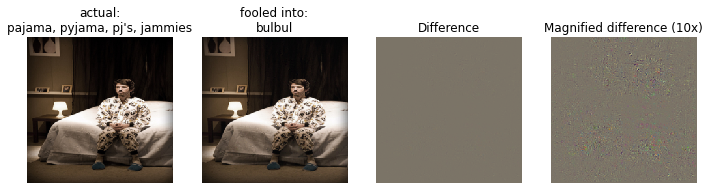

In [35]:
X_fooling_np = deprocess(X_fooling.cpu().clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title('actual:\n'+class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title('fooled into:\n'+class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx])).cuda()
X_diff = (X_fooling - X_pre).cpu()
diff = np.asarray(deprocess(X_diff, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_diff), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

---
---

# Congratulation, You've Completed Exercise 12 part 1

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)